<a href="https://colab.research.google.com/github/andssuu/redes_neurais_pos/blob/main/projeto/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Redes Neurais

# Introdução

O projeto consiste no desenvolvimento de um modelo para detecção de comportamentos do gado leiteiro por meio de dados de sensores (acelerômetro, giroscópio, magnetômetro e GPS) embutidos em uma coleira.

Comportamentos como andar, pastar, deitar e ócio são interessantes para otimização de recursos no manejo dos animais. Dentre tais informações de comportamento, é possível destacar a ruminação do animal na detecção de doenças e no cio. Portanto, monitorar os comportamentos dos animais é uma tarefa muito importante para ajudar o produtor numa melhor tomada de decisão.

Para realizar tal tarefa, este trabalho tem como objetivo avaliar a utilização de uma rede MultiLayer Perceptron (MLP) aplicando algumas técnicas de otimização. Comparações em relação à acurácia também foram realizadas.  


# Base de Dados

* 2 períodos: primeiro de 25/03/15 a 30/03/15 e de 06/04/15 a 09/04/15
* 4 animais (3 distintos)
* Foram utilizadas 4 coleiras (A, B, C e D). Entretanto, houve algumas falhas durante o experimento e, no final, ficaram as seguintes bases:
  - A2 e A3
  - B2 e B3
  - C3 e C4
  - D1, D2, D3 e D4

O arquivo lomba.csv contém todos os dados aglutinados que foram utilizados. A estrutura de cabeçalho é definida da seguinte forma:

IdColar | AccX | AccY | AccZ | MagX | MagY | MagZ | GirX | GirY | GirZ | Horario | Data | VelocidadeDeslocamento | Comportamento 
 --- | --- | --- |--- |--- |--- |--- |--- |--- |--- |--- |---|---|---
A2 | -11889 | 11184 | -17877 | -1280 | -73 | -309 | -4013 | 1260 | -31 | 131911.203 | 250515 | 000.0 | Comendo/Procurando
A2 | -9144 | 8945 | -11799 | -1213 | 707 | -238 | -394 | 2278 | -602 | 131949.203 | 250515 | 000.0 | Comendo/Procurando
A2 | 6391 | 9265 | -11767 | 570 | -405 | -1533 | -1072 | -1094 | 1854 | 132148.203 | 250515 | 000.0 | EmPe
A2 | -1394 | 10206 | -13229 | 671 | -73 | -1590 | 287 | 2253 | -2760 | 132151.203 | 250515 | 000.0 | Comendo/Procurando
...| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... 
D4 | 2152 | 7619 | -7736 | -1650 | 788 | 43 | -2980 | 3678 | -1357 | 122529.111 | 040715 | 000.0 | Comendo/Procurando


No total há 13088 amostras. A tabela a seguir mostra a segmentação das amostras por coleira

A2 | A3 | B2 | B3 | C3 | C4 | D1 | D2 | D3 | D4 | Total
--- | --- | --- |--- |--- |--- |--- |--- |--- |--- |--- | 
1112 | 2033 | 1131 | 1735 | 1852 | 406 | 1126 | 1690 | 1598 | 405 | 13088


# Visualização dos dados


In [ ]:
import math
from datetime import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv("moncattle/data/lomba.csv", float_precision='high')
df.head()


## Notebooks Sensores

* [Acelerômetro](https://colab.research.google.com/github/andssuu/moncattle/blob/master/visualization/notebooks/accelerometer.ipynb)

* [Giroscópio](https://colab.research.google.com/github/andssuu/moncattle/blob/master/visualization/notebooks/gyroscope.ipynb)

* [Magnetômetro](https://colab.research.google.com/github/andssuu/moncattle/blob/master/visualization/notebooks/magnetometer.ipynb)


# Arquitetura

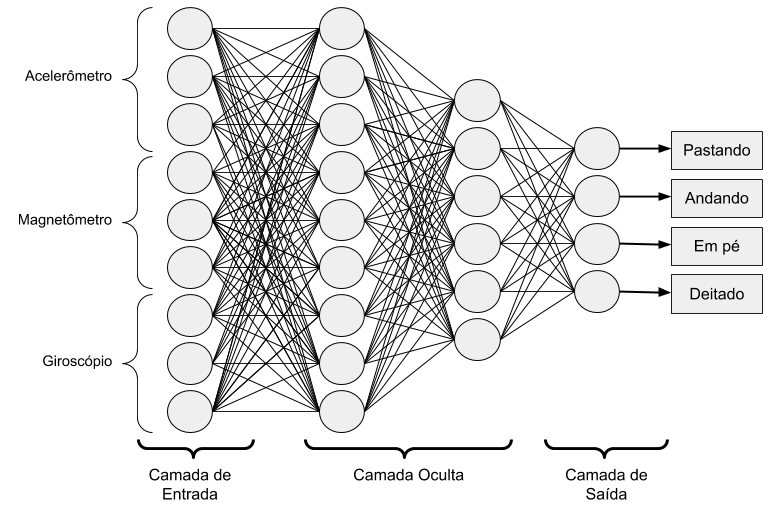


# Otimizações

*   L2
*   Momentum


# Resultados

